In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import random
from PIL import Image, ImageDraw
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torchvision
from torchvision import transforms as T
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

In [3]:
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))
# force_cudnn_initialization()

In [38]:
train_name = "game4" #name of the train folder
data = pd.read_csv("train/game4/" + train_name + "/formatted_data.csv")
#split it up into 50 pieces (original is 7000)
data = data[1:50]
data

,image_id,x1,y1,x2,y2
1,frame1298,1163,605,1177,619
2,frame1299,1151,610,1165,624
3,frame1300,1140,616,1154,630
4,frame1301,1130,623,1144,637
5,frame1302,1120,626,1134,640
6,frame1303,1112,623,1126,637
7,frame1304,1104,620,1118,634
8,frame1305,1095,618,1109,632
9,frame1306,1085,615,1099,629
10,frame1307,1077,613,1091,627


In [5]:
unique_imgs = data.image_id.unique()

In [6]:
class CustDat(torch.utils.data.Dataset):
    def __init__(self, df, unique_imgs, indicies):
        self.df = df
        self.unique_imgs = unique_imgs
        self.indicies = indicies
    def __len__(self):
        return len(self.indicies)
    def __getitem__(self, idx):
        image_name = self.unique_imgs[self.indicies[idx]]
        boxes = self.df[self.df.image_id == image_name].values[:, 1:].astype("float")
        img = Image.open("train/"+ train_name + "/images/" + image_name + ".jpg").convert('RGB')
        labels = torch.ones((boxes.shape[0]), dtype=torch.int64)
        target = {}
        target["boxes"] = torch.tensor(boxes)
        target["label"] = labels
        return T.ToTensor()(img) , target

In [7]:
train_inds , val_inds = train_test_split(range(unique_imgs.shape[0]) , test_size=0.1)

In [8]:
def custom_collate(data):
    return data

In [9]:
train_d1 = torch.utils.data.DataLoader(CustDat(data, unique_imgs, train_inds),
                                       batch_size = 8,
                                       shuffle = True,
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.cuda.is_available() else False)

val_d1 = torch.utils.data.DataLoader(CustDat(data, unique_imgs, val_inds),
                                       batch_size = 4,
                                       shuffle = True,
                                       collate_fn = custom_collate,
                                       pin_memory = True if torch.cuda.is_available() else False)


In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained = True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

c:\Users\hmhor\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hmhor\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [12]:
device

device(type='cuda')

In [12]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
num_epochs = 3

In [13]:
model.to(device)
for epochs in range(num_epochs):
    epoch_loss = 0
    for data in train_d1:
        imgs = []
        targets = []
        for d in data:
            imgs.append(d[0].to(device))
            targ = {}
            targ["boxes"] = d[1]["boxes"].to(device)
            targ["labels"] = d[1]["label"].to(device)
            targets.append(targ)
        loss_dict = model(imgs, targets)
        loss = sum(v for v in loss_dict.values())
        epoch_loss += loss.cpu().detach().numpy()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch_loss)


d in data 0 done
d in data 1 done
d in data 2 done
d in data 3 done
d in data 4 done
d in data 5 done
d in data 6 done
d in data 7 done
data 0 done
d in data 0 done
d in data 1 done
d in data 2 done
d in data 3 done
d in data 4 done
d in data 5 done
d in data 6 done
d in data 7 done
data 1 done
d in data 0 done
d in data 1 done
d in data 2 done
d in data 3 done
d in data 4 done
d in data 5 done
d in data 6 done
d in data 7 done
data 2 done
d in data 0 done
d in data 1 done
d in data 2 done
d in data 3 done
d in data 4 done
d in data 5 done
d in data 6 done
d in data 7 done
data 3 done
d in data 0 done
d in data 1 done
d in data 2 done
d in data 3 done
d in data 4 done
d in data 5 done
d in data 6 done
d in data 7 done
data 4 done
d in data 0 done
d in data 1 done
d in data 2 done
d in data 3 done
data 5 done
2.996944845836584
d in data 0 done
d in data 1 done
d in data 2 done
d in data 3 done
d in data 4 done
d in data 5 done
d in data 6 done
d in data 7 done
data 0 done
d in data 0 do

In [14]:
model.eval()
data1 = iter(val_d1).__next__()
data1

[[tensor([[[0.0235, 0.0118, 0.0039,  ..., 0.0078, 0.0078, 0.0078],
           [0.0275, 0.0196, 0.0039,  ..., 0.0078, 0.0118, 0.0118],
           [0.0392, 0.0314, 0.0235,  ..., 0.0118, 0.0118, 0.0118],
           ...,
           [0.4431, 0.4431, 0.4431,  ..., 0.3882, 0.3882, 0.3882],
           [0.4431, 0.4431, 0.4431,  ..., 0.3843, 0.3882, 0.3882],
           [0.4431, 0.4431, 0.4431,  ..., 0.3843, 0.3882, 0.3882]],
  
          [[0.0706, 0.0706, 0.0588,  ..., 0.0157, 0.0157, 0.0157],
           [0.0667, 0.0667, 0.0588,  ..., 0.0157, 0.0196, 0.0196],
           [0.0706, 0.0706, 0.0706,  ..., 0.0196, 0.0196, 0.0196],
           ...,
           [0.3922, 0.3922, 0.3922,  ..., 0.3490, 0.3529, 0.3529],
           [0.3922, 0.3922, 0.3922,  ..., 0.3529, 0.3529, 0.3529],
           [0.3922, 0.3922, 0.3922,  ..., 0.3529, 0.3529, 0.3529]],
  
          [[0.0627, 0.0588, 0.0627,  ..., 0.0118, 0.0118, 0.0118],
           [0.0706, 0.0667, 0.0588,  ..., 0.0118, 0.0157, 0.0157],
           [0.0824, 0.

In [39]:
img = data1[3][0]
boxes = data1[3][1]["boxes"]
labels = data1[3][1]["label"]

In [40]:
output = model([img.to(device)])

In [41]:
output

[{'boxes': tensor([[885.6652, 605.8192, 900.4207, 617.0978]], device='cuda:0',
         grad_fn=<StackBackward0>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.0647], device='cuda:0', grad_fn=<IndexBackward0>)}]

In [42]:
out_bbox = output[0]["boxes"]
out_scores = output[0]["scores"]

In [43]:
keep = torchvision.ops.nms(out_bbox, out_scores, 0.45)

In [44]:
out_bbox.shape, keep.shape

(torch.Size([1, 4]), torch.Size([1]))

tensor([], device='cuda:0', size=(0, 4), grad_fn=<StackBackward0>)

In [45]:
im = (img.permute(1,2,0).cpu().detach().numpy() * 255).astype('uint8')

In [46]:
im

array([[[  0,  18,  19],
        [  0,  17,  19],
        [  0,  16,  16],
        ...,
        [  3,   5,   2],
        [  3,   5,   0],
        [  3,   5,   0]],

       [[  0,  20,  21],
        [  0,  19,  20],
        [  1,  17,  17],
        ...,
        [  3,   5,   2],
        [  4,   6,   3],
        [  5,   7,   2]],

       [[  2,  24,  22],
        [  2,  22,  21],
        [  4,  19,  22],
        ...,
        [  3,   5,   2],
        [  4,   6,   3],
        [  6,   8,   5]],

       ...,

       [[114, 101,  31],
        [114, 101,  31],
        [114, 101,  31],
        ...,
        [ 99,  87,  27],
        [ 99,  87,  27],
        [ 99,  87,  27]],

       [[114, 101,  31],
        [114, 101,  31],
        [115, 100,  31],
        ...,
        [ 98,  88,  26],
        [ 99,  88,  26],
        [ 99,  88,  26]],

       [[113, 100,  30],
        [113, 100,  30],
        [114,  99,  30],
        ...,
        [ 98,  88,  26],
        [ 99,  88,  26],
        [ 99,  88,  26]]

In [47]:
vsample = Image.fromarray(im)

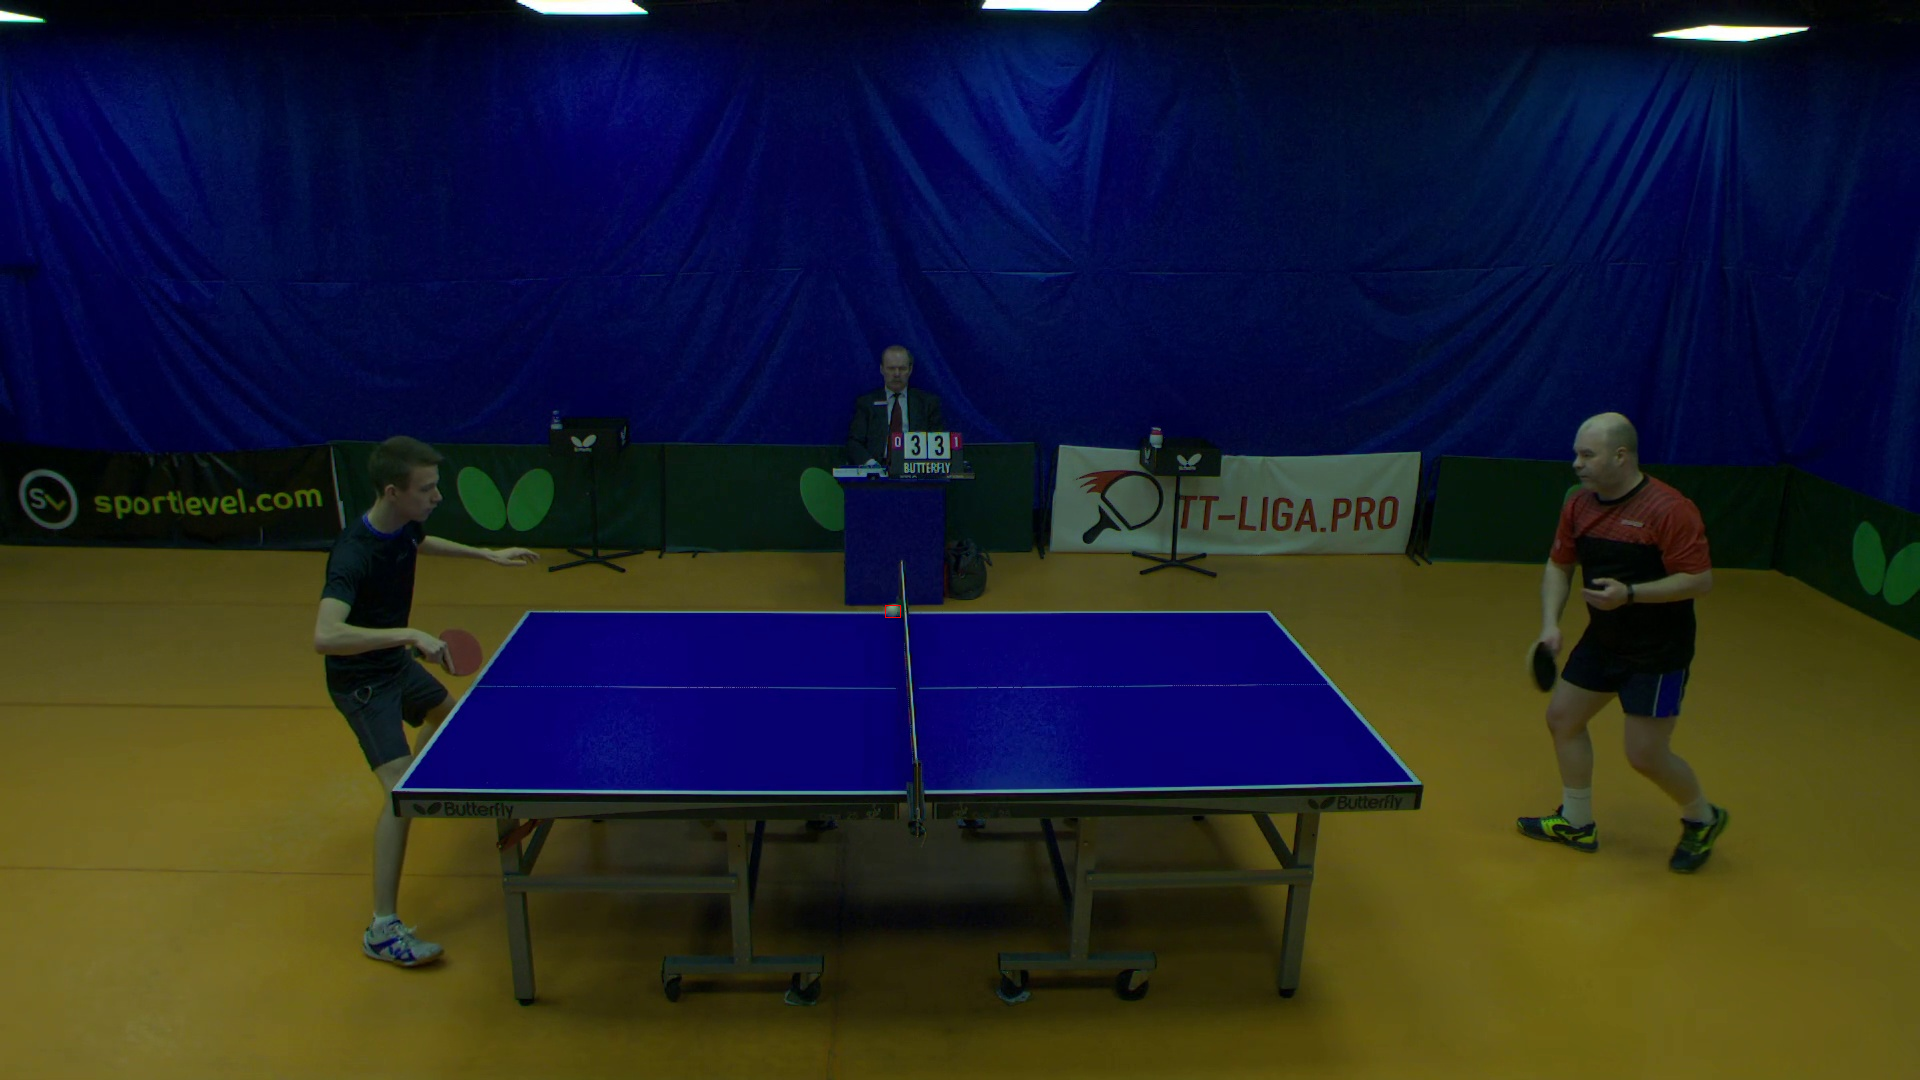

In [48]:
draw = ImageDraw.Draw(vsample)
for box in out_bbox:
    draw.rectangle(list(box), fill = None, outline="red")
vsample